In [2]:
 # Import Libraries
import os
import random
from glob import glob
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import zoom
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Visualizacion del conjunto de datos

Total de archivos .npy encontrados: 2625


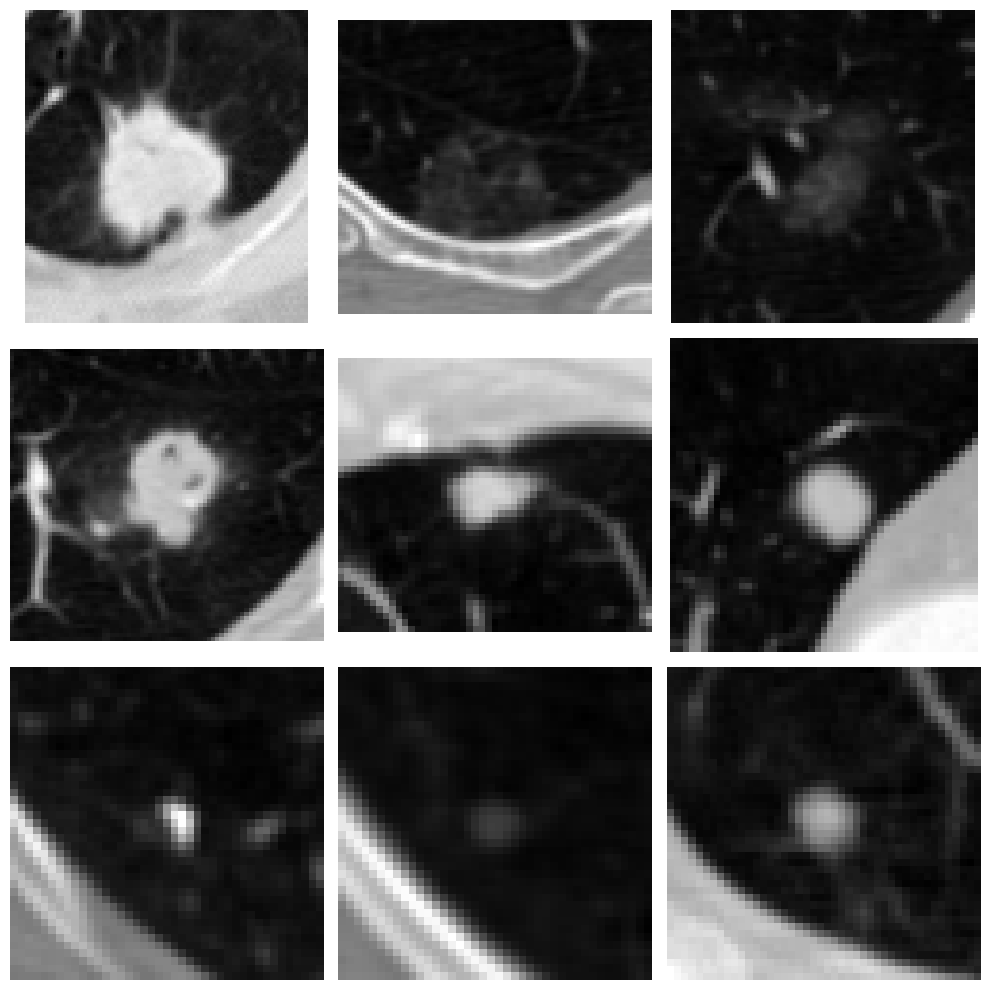

In [3]:
path_npy = "/kaggle/input/ia2dataset/LIDC-IDRI_images_npy_mean_HU/LIDC-IDRI_images_npy_mean_HU"
path_csv = "/kaggle/input/ia2dataset/dataset_LIDC_all_best_matches_2612.csv"

# ✅ Solo archivos .npy
files = sorted([f for f in glob(os.path.join(path_npy, "*")) if f.endswith(".npy")])

print(f"Total de archivos .npy encontrados: {len(files)}")

# Verifica las formas de los arrays
shapes = [np.load(f).shape for f in files]
#print("Formas únicas:", Counter(shapes))

# Carga unas pocas imágenes para visualizar
samples = [np.squeeze(np.load(f)) for f in files[:9]]

# Mostrar imágenes
plt.figure(figsize=(10, 10))
for i, img in enumerate(samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# 1️⃣ Cargar CSV
df = pd.read_csv(path_csv)

# 2️⃣ Extraer solo el nombre del archivo desde la ruta completa
# Ejemplo: /data/.../LICD-0003_NI000_slice004.npy -> LICD-0003_NI000_slice004.npy
df['filename'] = df['best_match'].apply(lambda x: os.path.basename(str(x).strip()))

# 3️⃣ Crear mapa filename → etiqueta
map_labels = dict(zip(df['filename'], df['malignancy_agg']))

# 4️⃣ Inicializar listas y contadores
X_list, Y_list = [], []
skipped_no_label, corrupt_files, csv_missing_files = [], [], []

# 5️⃣ Recorrer solo archivos .npy de la carpeta
for fname in os.listdir(path_npy):
    if not fname.lower().endswith('.npy'):
        continue  # ignorar xml, html, etc.

    full_path = os.path.join(path_npy, fname)
    label = map_labels.get(fname)

    if label is None:
        skipped_no_label.append(fname)
        continue

    try:
        img = np.load(full_path)
        X_list.append(img)
        Y_list.append(label)
    except Exception as e:
        corrupt_files.append((fname, str(e)))

# 6️⃣ Verificar archivos del CSV que no existen en la carpeta actual
for csv_fname in df['filename'].unique():
    if not os.path.exists(os.path.join(path_npy, csv_fname)):
        csv_missing_files.append(csv_fname)

# 7️⃣ Convertir a numpy arrays (maneja tamaños distintos)
try:
    X_data = np.stack(X_list)
except Exception:
    X_data = np.array(X_list, dtype=object)

Y_data = np.array(Y_list)

# 8️⃣ Resumen
print("✅ Datos organizados correctamente.")
print(f"Procesados: {len(X_list)}")
print(f"Sin etiqueta en CSV: {len(skipped_no_label)} -> {skipped_no_label[:5]}")
print(f"Corruptos: {len(corrupt_files)} -> {corrupt_files[:3]}")
print(f"CSV sin archivo .npy: {len(csv_missing_files)} -> {csv_missing_files[:5]}")
print("Shapes:")
print("  X_data:", getattr(X_data, 'shape', None))
print("  Y_data:", Y_data.shape)


✅ Datos organizados correctamente.
Procesados: 2612
Sin etiqueta en CSV: 13 -> ['LICD-0340_NI000_slice028.npy', 'LICD-0404_NI004_slice007.npy', 'LICD-0055_NI000_slice003.npy', 'LICD-0815_NI000_slice010.npy', 'LICD-0092_NI001_slice005.npy']
Corruptos: 0 -> []
CSV sin archivo .npy: 0 -> []
Shapes:
  X_data: (2612,)
  Y_data: (2612,)


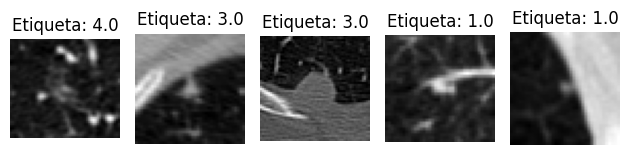

In [5]:
import matplotlib.pyplot as plt
import random

# Asegura que tienes datos
if len(X_data) == 0:
    print("⚠️ No hay imágenes cargadas en X_data.")
else:
    # Muestra 5 imágenes aleatorias
    indices = random.sample(range(len(X_data)), min(5, len(X_data)))

    for i, idx in enumerate(indices, 1):
        img = X_data[idx]
        label = Y_data[idx]

        plt.subplot(1, 5, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"Etiqueta: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
print("Valores únicos en 'malignancy_agg':")
print(df['malignancy_agg'].unique())
# Contar frecuencia de cada valor
print("\nFrecuencia:")
print(df['malignancy_agg'].value_counts())

Valores únicos en 'malignancy_agg':
[2. 5. 1. 3. 4.]

Frecuencia:
malignancy_agg
3.0    1181
2.0     570
1.0     340
4.0     315
5.0     206
Name: count, dtype: int64


Valores únicos en 'malignancy_agg':
[2. 5. 1. 3. 4.]

Frecuencia:
malignancy_agg
3.0    1181
2.0     570
1.0     340
4.0     315
5.0     206
Name: count, dtype: int64

ANÁLISIS ESTADÍSTICO - DISTRIBUCIÓN DE MALIGNIDAD

1. ESTADÍSTICAS DESCRIPTIVAS:
------------------------------------------------------------
Total de muestras: 2612
Media: 2.80
Mediana: 3.00
Moda: 3.0
Desviación estándar: 1.07
Varianza: 1.13
Mínimo: 1.0
Máximo: 5.0

2. PERCENTILES:
------------------------------------------------------------
Percentil 25: 2.00
Percentil 50: 3.00
Percentil 75: 3.00

3. DISTRIBUCIÓN DE FRECUENCIAS:
------------------------------------------------------------
Clase 1:  340 muestras (13.02%)
Clase 2:  570 muestras (21.82%)
Clase 3: 1181 muestras (45.21%)
Clase 4:  315 muestras (12.06%)
Clase 5:  206 muestras ( 7.89%)

4. ANÁLISIS DE BALANCE DE CLASES:
------------------------------------------------------------
Clase mayoritaria: 3 (1181 muestras)
Clase minoritaria: 5 (206 muestras)
Ratio d

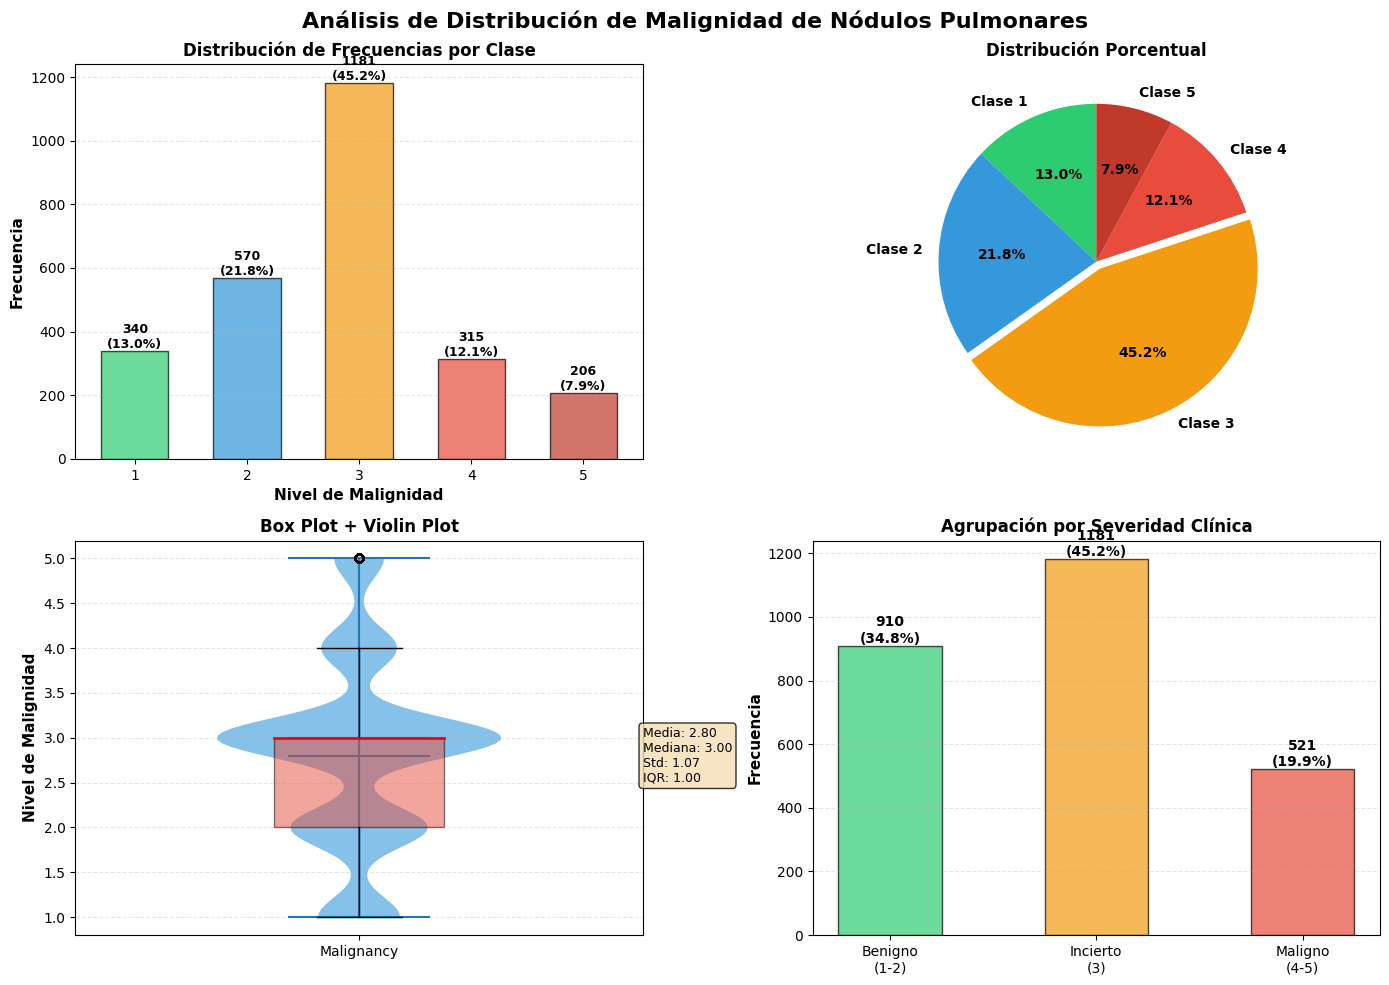

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# ============================================================================
# CARGAR Y EXPLORAR DATOS
# ============================================================================
print("Valores únicos en 'malignancy_agg':")
print(df['malignancy_agg'].unique())

# Contar frecuencia de cada valor
print("\nFrecuencia:")
frequency_series = df['malignancy_agg'].value_counts()
print(frequency_series)

# Convertir a diccionario para el análisis
frecuencias = frequency_series.to_dict()

# ============================================================================
# ANÁLISIS ESTADÍSTICO
# ============================================================================
print("\n" + "=" * 60)
print("ANÁLISIS ESTADÍSTICO - DISTRIBUCIÓN DE MALIGNIDAD")
print("=" * 60)

# 1. ESTADÍSTICAS BÁSICAS
print("\n1. ESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 60)

# Usar directamente la columna del DataFrame
all_values = df['malignancy_agg'].values

print(f"Total de muestras: {len(all_values)}")
print(f"Media: {np.mean(all_values):.2f}")
print(f"Mediana: {np.median(all_values):.2f}")
print(f"Moda: {df['malignancy_agg'].mode()[0]:.1f}")
print(f"Desviación estándar: {np.std(all_values):.2f}")
print(f"Varianza: {np.var(all_values):.2f}")
print(f"Mínimo: {np.min(all_values):.1f}")
print(f"Máximo: {np.max(all_values):.1f}")

# 2. PERCENTILES
print("\n2. PERCENTILES:")
print("-" * 60)
percentiles = [25, 50, 75]
for p in percentiles:
    print(f"Percentil {p}: {np.percentile(all_values, p):.2f}")

# 3. DISTRIBUCIÓN DE FRECUENCIAS
print("\n3. DISTRIBUCIÓN DE FRECUENCIAS:")
print("-" * 60)
total = len(df)
for malignancy in sorted(frecuencias.keys()):
    count = frecuencias[malignancy]
    percentage = (count / total) * 100
    print(f"Clase {int(malignancy)}: {count:4d} muestras ({percentage:5.2f}%)")

# 4. ANÁLISIS DE BALANCE DE CLASES
print("\n4. ANÁLISIS DE BALANCE DE CLASES:")
print("-" * 60)
max_count = max(frecuencias.values())
min_count = min(frecuencias.values())
max_class = max(frecuencias, key=frecuencias.get)
min_class = min(frecuencias, key=frecuencias.get)
ratio = max_count / min_count

print(f"Clase mayoritaria: {max_class:.0f} ({max_count} muestras)")
print(f"Clase minoritaria: {min_class:.0f} ({min_count} muestras)")
print(f"Ratio desbalance: {ratio:.2f}:1")

if ratio > 3:
    print("   ADVERTENCIA: Dataset significativamente desbalanceado")
    print("   Considera usar técnicas de balanceo (SMOTE, undersampling, etc.)")
else:
    print("✓  Dataset relativamente balanceado")

# 5. AGRUPACIÓN POR SEVERIDAD
print("\n5. AGRUPACIÓN POR SEVERIDAD:")
print("-" * 60)
benign = frecuencias.get(1.0, 0) + frecuencias.get(2.0, 0)  # Benigno/Probablemente benigno
uncertain = frecuencias.get(3.0, 0)  # Incierto
malign = frecuencias.get(4.0, 0) + frecuencias.get(5.0, 0)  # Probablemente maligno/Maligno

print(f"Benigno/Probablemente benigno (1-2): {benign} ({benign/total*100:.2f}%)")
print(f"Incierto (3): {uncertain} ({uncertain/total*100:.2f}%)")
print(f"Probablemente maligno/Maligno (4-5): {malign} ({malign/total*100:.2f}%)")

# 7. VISUALIZACIONES
print("\n6. GRÁFICAS")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Distribución de Malignidad de Nódulos Pulmonares', 
             fontsize=16, fontweight='bold')

# Gráfico 1: Distribución de frecuencias (barras)
ax1 = axes[0, 0]
classes = sorted(frecuencias.keys())
counts = [frecuencias[c] for c in classes]
colors_map = {1.0: '#2ecc71', 2.0: '#3498db', 3.0: '#f39c12', 4.0: '#e74c3c', 5.0: '#c0392b'}
bar_colors = [colors_map.get(c, '#95a5a6') for c in classes]

bars = ax1.bar(classes, counts, color=bar_colors, edgecolor='black', alpha=0.7, width=0.6)
ax1.set_xlabel('Nivel de Malignidad', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax1.set_title('Distribución de Frecuencias por Clase', fontsize=12, fontweight='bold')
ax1.set_xticks(classes)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores encima de las barras
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: Porcentaje (pie chart)
ax2 = axes[0, 1]
wedges, texts, autotexts = ax2.pie(counts, 
                                     labels=[f'Clase {int(c)}' for c in classes], 
                                     autopct='%1.1f%%', 
                                     colors=bar_colors, 
                                     startangle=90, 
                                     textprops={'fontweight': 'bold', 'fontsize': 10},
                                     explode=[0.05 if c == max_class else 0 for c in classes])
ax2.set_title('Distribución Porcentual', fontsize=12, fontweight='bold')

# Gráfico 3: Box plot + Violin plot
ax3 = axes[1, 0]
parts = ax3.violinplot([all_values], positions=[0], showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.6)

box = ax3.boxplot([all_values], positions=[0], widths=0.3, patch_artist=True,
                   boxprops=dict(facecolor='#e74c3c', alpha=0.5),
                   medianprops=dict(color='red', linewidth=2),
                   meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax3.set_ylabel('Nivel de Malignidad', fontweight='bold', fontsize=11)
ax3.set_title('Box Plot + Violin Plot', fontsize=12, fontweight='bold')
ax3.set_xticks([0])
ax3.set_xticklabels(['Malignancy'])
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar estadísticas al box plot
stats_text = (f"Media: {np.mean(all_values):.2f}\n"
              f"Mediana: {np.median(all_values):.2f}\n"
              f"Std: {np.std(all_values):.2f}\n"
              f"IQR: {np.percentile(all_values, 75) - np.percentile(all_values, 25):.2f}")
ax3.text(0.5, np.mean(all_values), stats_text, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         fontsize=9, verticalalignment='center')

# Gráfico 4: Agrupación por severidad
ax4 = axes[1, 1]
severity_groups = ['Benigno\n(1-2)', 'Incierto\n(3)', 'Maligno\n(4-5)']
severity_counts = [benign, uncertain, malign]
severity_colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars2 = ax4.bar(severity_groups, severity_counts, color=severity_colors, 
                edgecolor='black', alpha=0.7, width=0.5)
ax4.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax4.set_title('Agrupación por Severidad Clínica', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars2, severity_counts):
    height = bar.get_height()
    percentage = (height / total) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('analisis_malignidad.png', dpi=300, bbox_inches='tight')
print("✓ Visualizaciones guardadas en 'analisis_malignidad.png'")
plt.show()




# Preprocesamiento

## Conversión a 2 clases: Benigno - Maligno

CONVERSIÓN A 2 CLASES

Etiquetas originales:
  Shape: (2612,)
  Valores únicos: [1. 2. 3. 4. 5.]
  Rango: [1, 5]

Guardado grupo indeterminado:
  X_indet shape: (1181,)
  y_indet únicos: [3.]
 Archivos guardados: X_indeterminados.npy, y_indeterminados.npy

Conversión completada!

Etiquetas de 2 clases:
  Shape: (1431,)
  Valores únicos: [0 1]

DISTRIBUCIÓN DE LAS 2 CLASES

Total de muestras: 1431

Distribución por clase:
----------------------------------------------------------------------
Clase 0 - Benigno (1-2)       :  910 muestras (63.59%)
Clase 1 - Maligno (4-5)       :  521 muestras (36.41%)

MAPEO DETALLADO

Malignancy Original → Nueva Clase:
----------------------------------------------------------------------
  Malignancy 1 → Clase 0 (Benigno   ):  340 muestras
  Malignancy 2 → Clase 0 (Benigno   ):  570 muestras
  Malignancy 3 → Clase 0 (Indeterminado): 1181 muestras
  Malignancy 4 → Clase 1 (Maligno   ):  315 muestras
  Malignancy 5 → Clase 1 (Maligno   ):  206 muestras

G

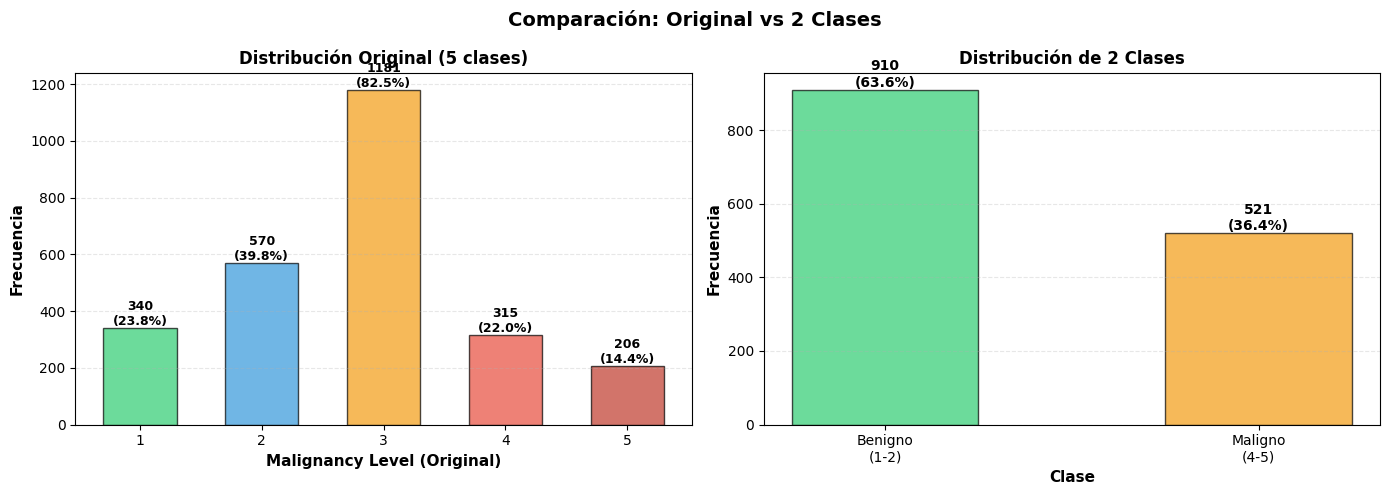

In [8]:
import numpy as np

# ============================================================================
# CONVERSIÓN A 2 CLASES: BENIGNO / MALIGNO
# ============================================================================

output_dir = '/kaggle/working'
np.save('/kaggle/working/y_data', Y_data)

def convert_to_two_classes(y_data):
    y_two_classes = np.full(len(y_data), -1, dtype=np.int32) 
    for i, malignancy in enumerate(y_data):
        if malignancy <= 2:
            y_two_classes[i] = 0  # Benigno
        if malignancy >= 4:  # malignancy >= 4
            y_two_classes[i] = 1  # Maligno
    return y_two_classes

# ============================================================================
# APLICAR CONVERSIÓN
# ============================================================================

print("=" * 70)
print("CONVERSIÓN A 2 CLASES")
print("=" * 70)

# Cargar etiquetas originales
y_data_original = np.load(f'{output_dir}/y_data.npy')

print(f"\nEtiquetas originales:")
print(f"  Shape: {y_data_original.shape}")
print(f"  Valores únicos: {np.unique(y_data_original)}")
print(f"  Rango: [{y_data_original.min():.0f}, {y_data_original.max():.0f}]")

# Máscaras
mask_benigno = (y_data_original >= 1) & (y_data_original <= 2)
mask_maligno = (y_data_original >= 4) & (y_data_original <= 5)
mask_indeterminado = (y_data_original == 3)

# Guardar indeterminados a parte
X_indet = X_data[mask_indeterminado]
y_indet = y_data_original[mask_indeterminado]

np.save(f"{output_dir}/X_indeterminados.npy", X_indet)
np.save(f"{output_dir}/y_indeterminados.npy", y_indet)

print("\nGuardado grupo indeterminado:")
print(f"  X_indet shape: {X_indet.shape}")
print(f"  y_indet únicos: {np.unique(y_indet)}")
print(" Archivos guardados: X_indeterminados.npy, y_indeterminados.npy")

# Filtración de datos y conversión a 2 clases
mask_valid = mask_benigno | mask_maligno
X_filtered = X_data[mask_valid]
y_filtered = y_data_original[mask_valid]

y_two_classes = convert_to_two_classes(y_filtered) 
# Se filtran también las imágenes
X_data = X_data[mask_valid]   

print(f"\nConversión completada!")
print(f"\nEtiquetas de 2 clases:")
print(f"  Shape: {y_two_classes.shape}")
print(f"  Valores únicos: {np.unique(y_two_classes)}")

# ============================================================================
# ANÁLISIS DE DISTRIBUCIÓN
# ============================================================================

print("\n" + "=" * 70)
print("DISTRIBUCIÓN DE LAS 2 CLASES")
print("=" * 70)

class_names = {0: 'Benigno (1-2)', 1: 'Maligno (4-5)'}
total = len(y_two_classes)

print(f"\nTotal de muestras: {total}")
print("\nDistribución por clase:")
print("-" * 70)

for class_id in [0, 1]:
    count = np.sum(y_two_classes == class_id)
    percentage = (count / total) * 100
    print(f"Clase {class_id} - {class_names[class_id]:20s}: {count:4d} muestras ({percentage:5.2f}%)")

# ============================================================================
# MAPEO DETALLADO
# ============================================================================

print("\n" + "=" * 70)
print("MAPEO DETALLADO")
print("=" * 70)

print("\nMalignancy Original → Nueva Clase:")
print("-" * 70)

for malignancy in sorted(np.unique(y_data_original)):
    if malignancy <= 2:
        new_class = 0
        class_name = "Benigno"
    elif malignancy == 3:
        class_name = "Indeterminado"
    else:
        new_class = 1
        class_name = "Maligno"
    
    count = np.sum(y_data_original == malignancy)
    print(f"  Malignancy {int(malignancy)} → Clase {new_class} ({class_name:10s}): {count:4d} muestras")

# ============================================================================
# GUARDAR ETIQUETAS DE 2 CLASES
# ============================================================================

print("\n" + "=" * 70)
print("GUARDANDO ETIQUETAS")
print("=" * 70)

# Guardar etiquetas de 2 clases
np.save(f'{output_dir}/y_data_2classes.npy', y_two_classes)
print(f"✅ Guardado: {output_dir}/y_data_2classes.npy")

# Guardar mapeo de nombres (opcional)
class_mapping = {
    0: "Benigno (malignancy 1-2)",
    1: "Maligno (malignancy 4-5)"
}
np.save(f'{output_dir}/class_mapping.npy', class_mapping)
print(f"✅ Guardado: {output_dir}/class_mapping.npy")

# ============================================================================
# VISUALIZACIÓN DE DISTRIBUCIÓN
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribución original (1-5)
ax = axes[0]
unique_original, counts_original = np.unique(y_data_original, return_counts=True)
colors_original = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#c0392b']
bars1 = ax.bar(unique_original, counts_original, color=colors_original[:len(unique_original)], 
               edgecolor='black', alpha=0.7, width=0.6)
ax.set_xlabel('Malignancy Level (Original)', fontweight='bold', fontsize=11)
ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax.set_title('Distribución Original (5 clases)', fontsize=12, fontweight='bold')
ax.set_xticks(unique_original)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars1, counts_original):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({count/total*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Distribución de 2 clases
ax = axes[1]
unique_two, counts_two = np.unique(y_two_classes, return_counts=True)
colors_two = ['#2ecc71', '#f39c12']
bars2 = ax.bar(unique_two, counts_two, color=colors_two, 
               edgecolor='black', alpha=0.7, width=0.5)
ax.set_xlabel('Clase', fontweight='bold', fontsize=11)
ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax.set_title('Distribución de 2 Clases', fontsize=12, fontweight='bold')
ax.set_xticks(unique_two)
ax.set_xticklabels(['Benigno\n(1-2)', 'Maligno\n(4-5)'])
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars2, counts_two):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({count/total*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Comparación: Original vs 2 Clases', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/distribucion_2clases.png', dpi=300, bbox_inches='tight')
print(f"✅ Gráfico guardado: {output_dir}/distribucion_2clases.png")
plt.show()

In [9]:
print("Después de filtrar indeterminados:")
print("  X_data:", X_data.shape)
print("  y_two_classes:", y_two_classes.shape)
print("  Clases:", np.unique(y_two_classes))

Después de filtrar indeterminados:
  X_data: (1431,)
  y_two_classes: (1431,)
  Clases: [0 1]


## Resize y generación de los datasets

In [10]:
import numpy as np
import cv2 as cv
from tqdm import tqdm
import os

# RESIZE
def resize_dataset_adaptive(images, target_size=(224, 224)):
    resized = []
    for img in tqdm(images, desc=f"Redimensionando a {target_size}"):
        # Asegurar que sea 2D
        if len(img.shape) == 3:
            img = img.squeeze()
        # Detectar si es upscaling o downscaling
        original_area = img.shape[0] * img.shape[1]
        target_area = target_size[0] * target_size[1]
        
        if original_area < target_area:
            method = cv.INTER_CUBIC
        else:
            if target_size == (32, 32):
                method = cv.INTER_AREA
            else:
                method = cv.INTER_CUBIC
        
        resized_img = cv.resize(img, target_size, interpolation=method)
        resized.append(resized_img)
    return np.array(resized)

# NORMALIZACION (MIN MAX)

def normalize_hounsfield_to_255_then_minmax(images, window_center=-600, window_width=1500):
    normalized = []
    
    # Windowing Hounsfield
    img_min_hu = window_center - window_width // 2
    img_max_hu = window_center + window_width // 2
    
    print(f"Windowing HU: [{img_min_hu}, {img_max_hu}]")
    # Aplicar windowing y convertir a [0, 255]
    for img in tqdm(images, desc="Normalizando (HU→255)"):
        # Windowing
        img_windowed = np.clip(img, img_min_hu, img_max_hu)
        # Escalar a [0, 255]
        img_255 = ((img_windowed - img_min_hu) / (img_max_hu - img_min_hu)) * 255.0
        normalized.append(img_255)
    normalized = np.array(normalized)
    print(f"Rango después de paso 1: [{normalized.min():.2f}, {normalized.max():.2f}]")
    
    # Min-Max Scaler
    print(f"Paso 2 - Min-Max Scaler [0, 1]")
    global_min = normalized.min()
    global_max = normalized.max()
    normalized = (normalized - global_min) / (global_max - global_min)
    print(f"Rango final: [{normalized.min():.4f}, {normalized.max():.4f}]")
    
    return normalized
    
def get_min_max_from_list(images):
    """
    Calcula min y max de una lista de arrays con diferentes tamaños
    """
    min_val = float('inf')
    max_val = float('-inf')
    
    for img in images:
        img_min = np.min(img)
        img_max = np.max(img)
        
        if img_min < min_val:
            min_val = img_min
        if img_max > max_val:
            max_val = img_max
    
    return min_val, max_val

# ============================================================================
# PROCESAR Y GUARDAR LOS 2 CONJUNTOS
# ============================================================================

# Crear directorio para guardar
os.makedirs(output_dir, exist_ok=True)

print("=" * 70)
print("GENERACIÓN DE 2 CONJUNTOS DE DATOS")
print("=" * 70)
min_val, max_val = get_min_max_from_list(X_data)
print(f"\nDataset original: {X_data.shape}")
print(f"Etiquetas: {Y_data.shape}")
print(f"  Rango HU: [{min_val:.1f}, {max_val:.1f}]")
print(f"\nNormalización: HU → [0, 255] → Min-Max [0, 1]")

# ----------------------------------------------------------------------------
# CONJUNTO 1: 32x32 (Comunmente utilizado en el estado del arte)
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📦 CONJUNTO 1: 32x32 (COMUNMENTE UTILIZADO EN EL ESTADO DEL ARTE)")
print("=" * 70)

X_data_32 = resize_dataset_adaptive(X_data, target_size=(32, 32))
X_data_32_norm = normalize_hounsfield_to_255_then_minmax(X_data_32)
X_data_32_norm = np.expand_dims(X_data_32_norm, axis=-1)

print(f"   Shape final: {X_data_32_norm.shape}")
print(f"   Memoria: {X_data_32_norm.nbytes / (1024**2):.2f} MB")

# Guardar
np.save('/kaggle/working/X_data_32x32.npy', X_data_32_norm)


# ----------------------------------------------------------------------------
# CONJUNTO 3: 224x224 (Transfer Learning)
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📦 CONJUNTO 2: 224x224 (Transfer Learning)")
print("=" * 70)

X_data_224 = resize_dataset_adaptive(X_data, target_size=(224, 224))
X_data_224_norm = normalize_hounsfield_to_255_then_minmax(X_data_224)

# Para transfer learning, convertir a 3 canales (RGB simulado)
# Muchos modelos pre-entrenados esperan 3 canales
X_data_224_rgb = np.stack([X_data_224_norm]*3, axis=-1)

print(f"   Shape final: {X_data_224_rgb.shape}")
print(f"   Memoria: {X_data_224_rgb.nbytes / (1024**2):.2f} MB")

# Guardar versión 1 canal y 3 canales

np.save('/kaggle/working/X_data_224x224.npy', X_data_224_rgb)

print(f"💾 Guardado: {output_dir}/X_data_224x224.npy (3 canales - RGB)")


# ----------------------------------------------------------------------------
# RESUMEN FINAL
# ----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("GENERACIÓN COMPLETADA")
print("=" * 70)

summary = f"""

   X_32 = np.load('{output_dir}/X_data_32x32.npy')
   X_224_3ch = np.load('{output_dir}/X_data_224x224_3ch.npy')
   y = np.load('{output_dir}/y_data')
"""
print(summary)

GENERACIÓN DE 2 CONJUNTOS DE DATOS

Dataset original: (1431,)
Etiquetas: (2612,)
  Rango HU: [-2048.0, 3071.0]

Normalización: HU → [0, 255] → Min-Max [0, 1]

📦 CONJUNTO 1: 32x32 (COMUNMENTE UTILIZADO EN EL ESTADO DEL ARTE)


Redimensionando a (32, 32): 100%|██████████| 1431/1431 [00:00<00:00, 45975.80it/s]


Windowing HU: [-1350, 150]


Normalizando (HU→255): 100%|██████████| 1431/1431 [00:00<00:00, 55819.51it/s]


Rango después de paso 1: [0.00, 255.00]
Paso 2 - Min-Max Scaler [0, 1]
Rango final: [0.0000, 1.0000]
   Shape final: (1431, 32, 32, 1)
   Memoria: 11.18 MB

📦 CONJUNTO 2: 224x224 (Transfer Learning)


Redimensionando a (224, 224): 100%|██████████| 1431/1431 [00:00<00:00, 4038.51it/s]


Windowing HU: [-1350, 150]


Normalizando (HU→255): 100%|██████████| 1431/1431 [00:00<00:00, 2322.13it/s]


Rango después de paso 1: [0.00, 255.00]
Paso 2 - Min-Max Scaler [0, 1]
Rango final: [0.0000, 1.0000]
   Shape final: (1431, 224, 224, 3)
   Memoria: 1643.41 MB
💾 Guardado: /kaggle/working/X_data_224x224.npy (3 canales - RGB)

GENERACIÓN COMPLETADA


   X_32 = np.load('/kaggle/working/X_data_32x32.npy')
   X_224_3ch = np.load('/kaggle/working/X_data_224x224_3ch.npy')
   y = np.load('/kaggle/working/y_data')



In [11]:
# Cargar los datasets procesados
X_32 = np.load(f'{output_dir}/X_data_32x32.npy')
X_224_3ch = np.load(f'{output_dir}/X_data_224x224.npy')
y_data = np.load(f'{output_dir}/y_data_2classes.npy')

✅ Visualización guardada en: comparacion_redimensiones_con_original.png


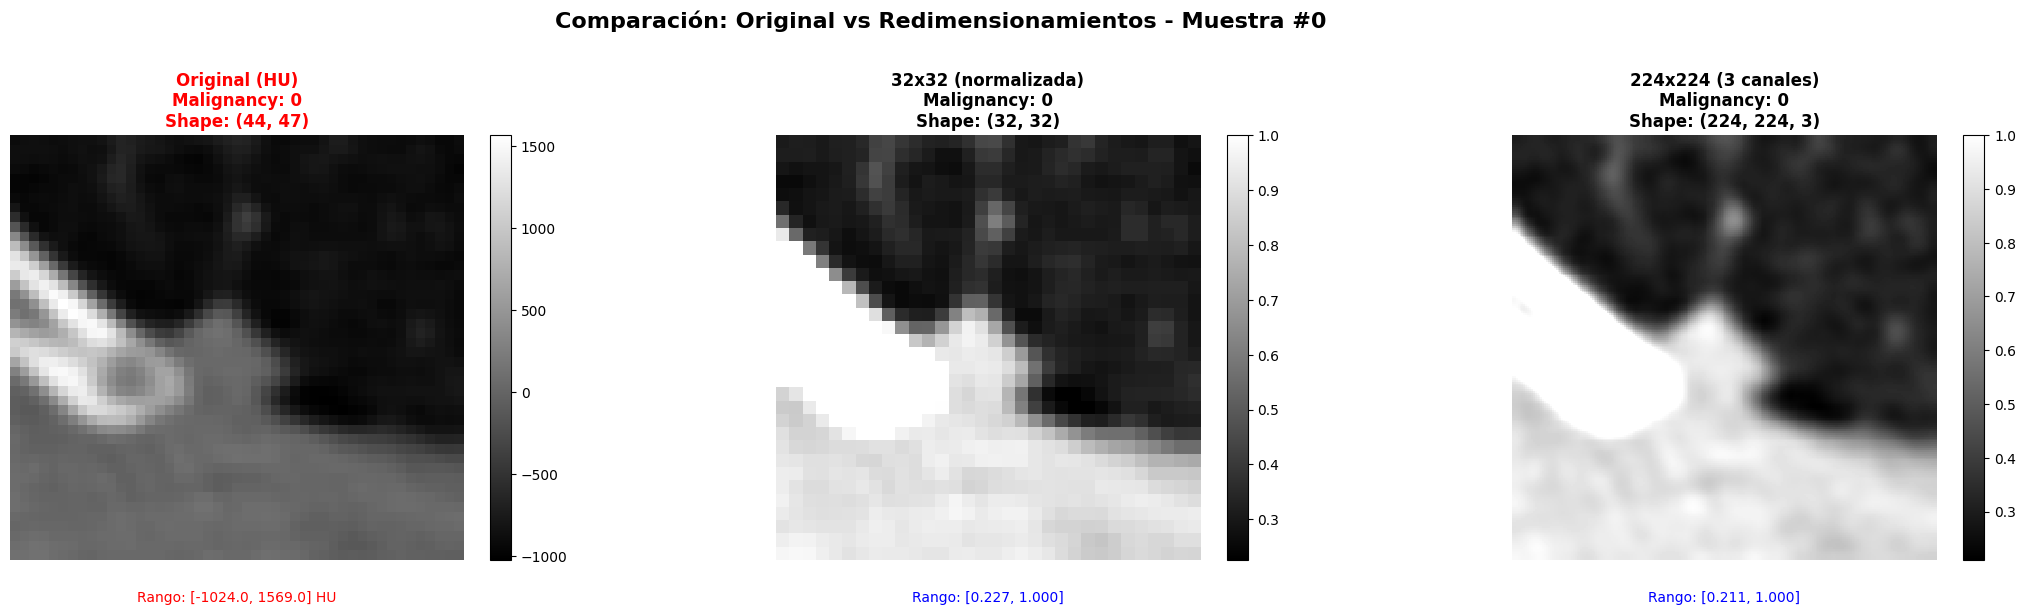

In [12]:
# Obtener la imagen original (sin procesar)
sample_idx = 0
sample_original = X_data[sample_idx]
if len(sample_original.shape) == 3:
    sample_original = sample_original.squeeze()

# Obtener las muestras procesadas
sample_32 = X_32[sample_idx].squeeze()
sample_224_3ch = X_224_3ch[sample_idx][:, :, 0]  # Tomar solo un canal (son iguales)

# Crear visualización
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Configuración común
malignancy_label = y_data[sample_idx]

# Plot 0: Original
ax = axes[0]
im0 = ax.imshow(sample_original, cmap='gray', interpolation='nearest')
ax.set_title(f'Original (HU)\nMalignancy: {malignancy_label:.0f}\nShape: {sample_original.shape}',
             fontsize=12, fontweight='bold', color='red')
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)
ax.text(0.5, -0.1, f'Rango: [{sample_original.min():.1f}, {sample_original.max():.1f}] HU',
        ha='center', transform=ax.transAxes, fontsize=10, color='red')

# Plot 1: 32x32
ax = axes[1]
im1 = ax.imshow(sample_32, cmap='gray', interpolation='nearest')
ax.set_title(f'32x32 (normalizada)\nMalignancy: {malignancy_label:.0f}\nShape: {sample_32.shape}',
             fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
ax.text(0.5, -0.1, f'Rango: [{sample_32.min():.3f}, {sample_32.max():.3f}]',
        ha='center', transform=ax.transAxes, fontsize=10, color='blue')

# Plot 3: 224x224 (3 canales)
ax = axes[2]
im3 = ax.imshow(sample_224_3ch, cmap='gray', interpolation='nearest')
ax.set_title(f'224x224 (3 canales)\nMalignancy: {malignancy_label:.0f}\nShape: {X_224_3ch[sample_idx].shape}',
             fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)
ax.text(0.5, -0.1, f'Rango: [{sample_224_3ch.min():.3f}, {sample_224_3ch.max():.3f}]',
        ha='center', transform=ax.transAxes, fontsize=10, color='blue')

# Título general
plt.suptitle(f'Comparación: Original vs Redimensionamientos - Muestra #{sample_idx}', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('comparacion_redimensiones_con_original.png', dpi=300, bbox_inches='tight')
print(f"✅ Visualización guardada en: comparacion_redimensiones_con_original.png")
plt.show()

## Particion de los datos

In [13]:
# Cargar datos
print(f"X_data shape: {X_32.shape}")
print(f"y_data shape: {y_data.shape}")
print(f"Clases: {np.unique(y_data)}")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_32,
    y_two_classes,
    test_size=0.20,      # 20% (10+10)
    random_state=42,
    stratify=y_two_classes
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,      # 50% del 20% = 10% del total
    random_state=42,
    stratify=y_temp
)

# Convertir a categorical DESPUÉS del split
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(f"\nTrain: {X_train.shape}, {y_train.shape}, \nValidation: {X_val.shape}, {y_val.shape} \nTest: {X_test.shape}, {y_test.shape}")

X_data shape: (1431, 32, 32, 1)
y_data shape: (1431,)
Clases: [0 1]

Train: (1144, 32, 32, 1), (1144, 2), 
Validation: (143, 32, 32, 1), (143, 2) 
Test: (144, 32, 32, 1), (144, 2)


# DNN

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
model_DNN = keras.Sequential([
        # Input
        layers.Flatten(input_shape=X_train.shape[1:]),
        # Bloque 1
        layers.Dense(2048, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),  # PReLU aprende el mejor slope
        layers.Dropout(0.3),
        
        layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),
        layers.Dropout(0.35),
        
        # Bloque 2
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),
        layers.Dropout(0.4),
        
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),
        layers.Dropout(0.45),
        
        # Bloque 3
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),
        layers.Dropout(0.5),
        
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.PReLU(),
        layers.Dropout(0.5),
        #Clasificacion
        layers.Dense(2, activation='softmax')
    ])
model_DNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1764012863.991329      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 2048)           │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 1024)           │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,914,946 (18.75 MB)

 Trainable params: 4,906,882 (18.72 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, initial_lr=1e-4)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_DNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall','auc'])

Epoch 1/50


I0000 00:00:1764003736.622007     139 service.cc:148] XLA service 0x7eb840002850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764003736.622655     139 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764003737.526214     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


38/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5588 - auc: 0.5540 - loss: 4.9482 - precision: 0.5588 - recall: 0.5588 

I0000 00:00:1764003742.395937     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.5705 - auc: 0.5747 - loss: 4.9384 - precision: 0.5705 - recall: 0.5705 - val_accuracy: 0.5385 - val_auc: 0.5750 - val_loss: 4.9509 - val_precision: 0.5385 - val_recall: 0.5385 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6092 - auc: 0.6281 - loss: 4.7895 - precision: 0.6092 - recall: 0.6092 - val_accuracy: 0.6853 - val_auc: 0.7007 - val_loss: 4.4668 - val_precision: 0.6853 - val_recall: 0.6853 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5909 - auc: 0.6554 - loss: 4.4480 - precision: 0.5909 - recall: 0.5909 - val_accuracy: 0.7413 - val_auc: 0.7812 - val_loss: 4.0728 - val_precision: 0.7413 - val_recall: 0.7413 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7002 - auc: 0.7308 - loss: 4.0495 - precision: 0.7002 - recall: 0.7002 - val_accuracy: 0.7413 - val_auc: 0.8002 - val_loss: 3.7189 - val_precision: 0.74

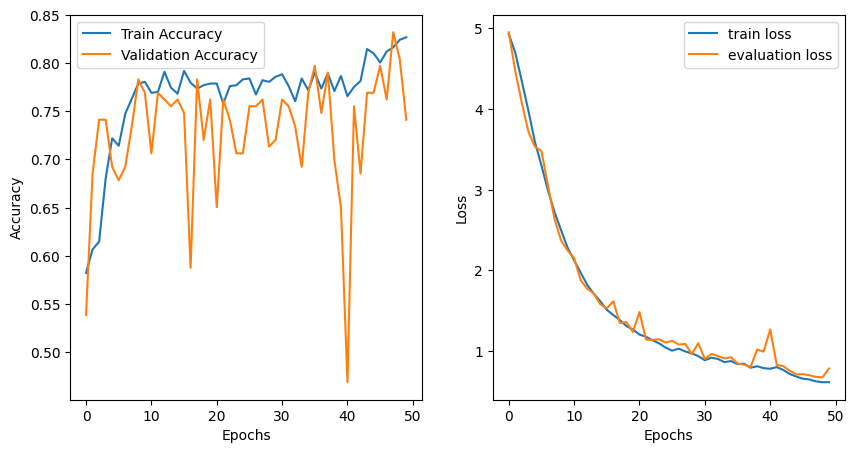

In [18]:
# Train the model
history32 = model_DNN.fit(X_train, y_train, epochs = 50, batch_size = 16, validation_data = (X_val, y_val), callbacks = [reduce_lr,early_stopping])

# Show the loss and accuracy of the model
fig = plt.figure(figsize = (10,5))

#Accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(history32.history['accuracy'], label = 'Train Accuracy');
ax.plot(history32.history['val_accuracy'], label = 'Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();

#Loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(history32.history['loss'], label = 'train loss');
ax.plot(history32.history['val_loss'], label = 'evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8100 - auc: 0.8428 - loss: 0.6938 - precision: 0.8100 - recall: 0.8100  
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


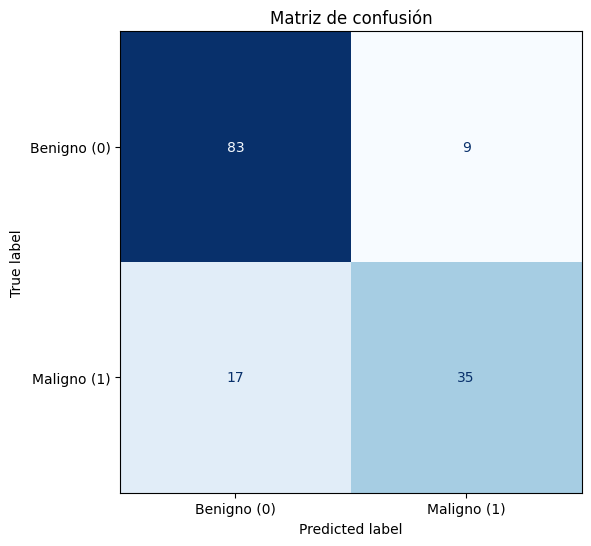

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

model_DNN.evaluate(X_test, y_test)
y_pred_proba = model_DNN.predict(X_test)
# Asegura que los vectores estén 1D
y_score = y_pred_proba  # probabilidades para todas las clases
y_true = np.argmax(y_test, axis=1)  # etiquetas verdaderas 0/1
y_hat = np.argmax(y_pred_proba, axis=1)  # predicciones 0/1

# 1) Matriz de confusión (absoluta)
cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
ax.set_title('Matriz de confusión')
plt.tight_layout()
plt.show()

(144, 2)


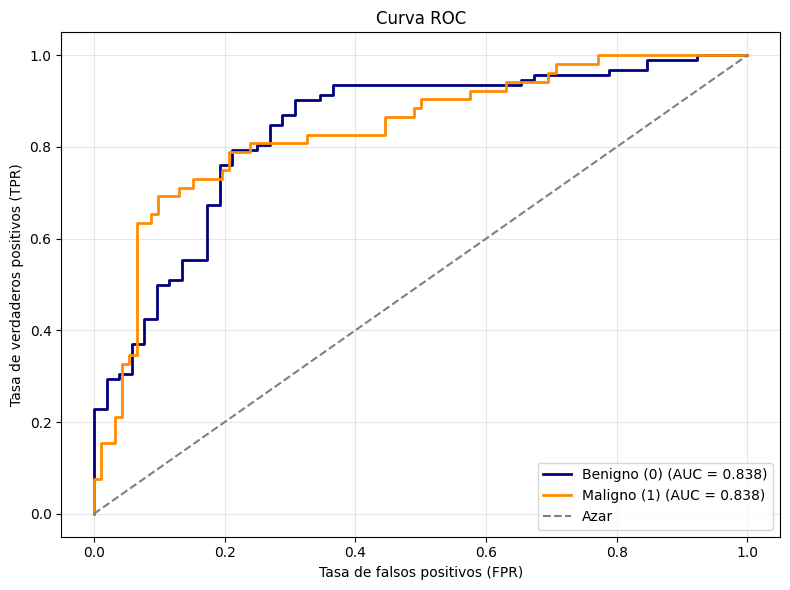

In [21]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

n_classes = 2
y_test_bin = label_binarize(y_test, classes=[0, 1])

print(y_test_bin.shape)

# 2) Curva ROC y AUC (multiclase)
plt.figure(figsize=(8, 6))

colors = cycle(['navy', 'darkorange'])
class_names = ['Benigno (0)', 'Maligno (1)']

for i, color, name in zip(range(3), colors, class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], '--', color='gray', label='Azar')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Modelo 1 : CNN

## CNN Simple

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    # Rotar
    rotation_range=20,  # ±20 grados (nódulos no tienen orientación fija)
    # Traslacion
    width_shift_range=0.15,  # 15% horizontal
    height_shift_range=0.15,  # 15% vertical
    # Zoom
    zoom_range=0.15,  # ±15% 
    # Flips Horizontales
    horizontal_flip=True,
    # Rellenado de bordes
    fill_mode='constant',  # Usar 0 (negro) para CT
    cval=0.0
)
val_test_datagen = ImageDataGenerator()

In [20]:
from tensorflow import keras

model_CNN = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2), padding='same'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2), padding='same'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2), padding='same'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(2, activation='softmax')  # 2 clases
])

model_CNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,506 (1.35 MB)

 Trainable params: 353,058 (1.35 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
#Compilar el modelo
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_CNN.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy','precision','recall','auc'])

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, initial_lr=1e-3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=16,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val, y_val,
    batch_size=16,
    shuffle=False
)

historyCNN = model_CNN.fit(
    train_generator,                # Generador como primer argumento
    epochs=50,
    validation_data=val_generator,  # o (X_val, y_val)
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1764015088.351542     112 service.cc:148] XLA service 0x7b2334002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764015088.352370     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764015089.070117     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4971 - auc: 0.5454 - loss: 0.8467 - precision: 0.4971 - recall: 0.4971

I0000 00:00:1764015093.693312     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.5953 - auc: 0.6441 - loss: 0.7421 - precision: 0.5953 - recall: 0.5953 - val_accuracy: 0.6294 - val_auc: 0.7067 - val_loss: 0.6628 - val_precision: 0.6294 - val_recall: 0.6294 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6676 - auc: 0.7266 - loss: 0.6385 - precision: 0.6676 - recall: 0.6676 - val_accuracy: 0.6783 - val_auc: 0.7523 - val_loss: 0.6145 - val_precision: 0.6783 - val_recall: 0.6783 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7042 - auc: 0.7677 - loss: 0.5816 - precision: 0.7042 - recall: 0.7042 - val_accuracy: 0.6503 - val_auc: 0.7511 - val_loss: 0.6251 - val_precision: 0.6503 - val_recall: 0.6503 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6659 - auc: 0.7392 - loss: 0.6129 - precision: 0.6659 - recall: 0.6659 - val_accuracy: 0.6993 - val_auc: 0.7497 - val_loss: 0.6396 - val_precision: 0

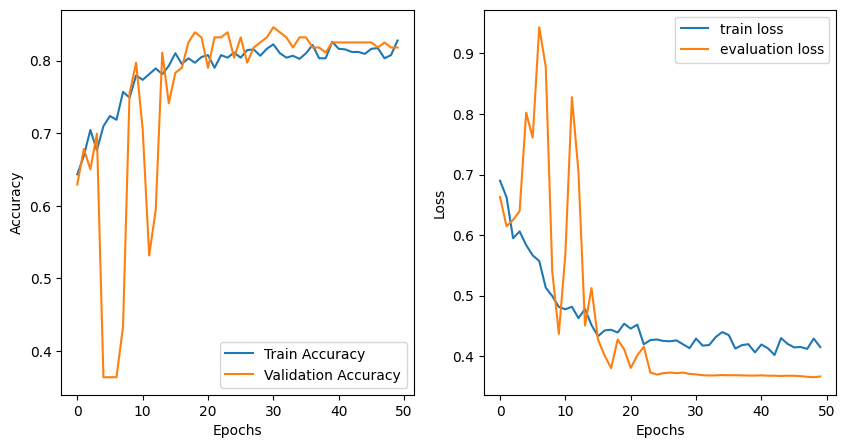

In [24]:
#gráficas
fig = plt.figure(figsize = (10,5))

#Accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(historyCNN.history['accuracy'], label = 'Train Accuracy');
ax.plot(historyCNN.history['val_accuracy'], label = 'Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();

#Loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(historyCNN.history['loss'], label = 'train loss');
ax.plot(historyCNN.history['val_loss'], label = 'evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8050 - auc: 0.8857 - loss: 0.4256 - precision: 0.8050 - recall: 0.8050
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


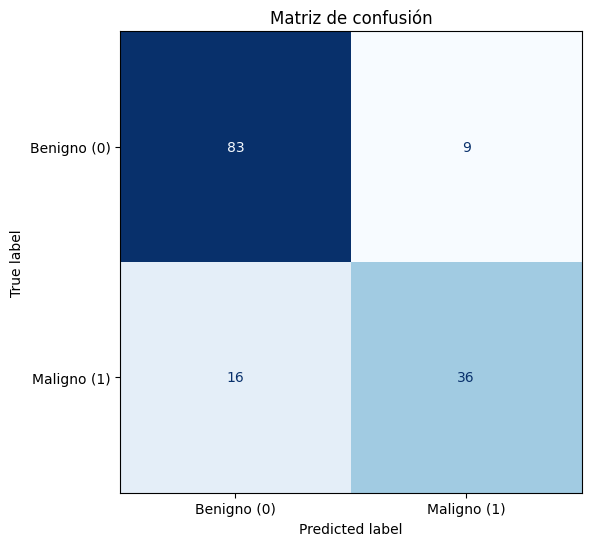

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

model_CNN.evaluate(X_test, y_test)
y_pred_proba = model_CNN.predict(X_test)
# Asegura que los vectores estén 1D
y_score = y_pred_proba  # probabilidades para todas las clases
y_true = np.argmax(y_test, axis=1)  # etiquetas verdaderas 0/1
y_hat = np.argmax(y_pred_proba, axis=1)  # predicciones 0/1

# 1) Matriz de confusión (absoluta)
cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
ax.set_title('Matriz de confusión')
plt.tight_layout()
plt.show()

(144, 2)


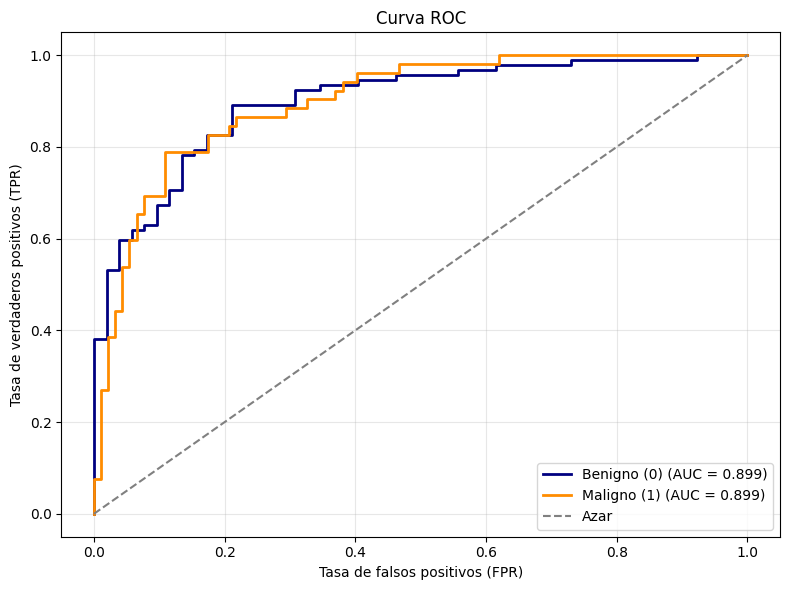

In [21]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

n_classes = 2
y_test_bin = label_binarize(y_test, classes=[0, 1])

print(y_test_bin.shape)

# 2) Curva ROC y AUC (multiclase)
plt.figure(figsize=(8, 6))

colors = cycle(['navy', 'darkorange'])
class_names = ['Benigno (0)', 'Maligno (1)']

for i, color, name in zip(range(3), colors, class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], '--', color='gray', label='Azar')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## CNN TF + Fine Tuning

In [27]:
# Partición para modelo con fine tuning
# Cargar datos
print(f"X_data shape: {X_224_3ch.shape}")
print(f"y_data shape: {y_data.shape}")
print(f"Clases: {np.unique(y_data)}")

X_train_224, X_temp_224, y_train, y_temp = train_test_split(
    X_224_3ch,
    y_two_classes,
    test_size=0.20,      # 20% (10+10)
    random_state=42,
    stratify=y_two_classes
)


X_val_224, X_test_224, y_val, y_test = train_test_split(
    X_temp_224,
    y_temp,
    test_size=0.50,      # 50% del 20% = 10% del total
    random_state=42,
    stratify=y_temp
)

# Convertir a categorical DESPUÉS del split
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(f"\nTrain: {X_train_224.shape}, {y_train.shape}, \nValidation: {X_val_224.shape}, {y_val.shape} \nTest: {X_test_224.shape}, {y_test.shape}")

X_data shape: (1431, 224, 224, 3)
y_data shape: (1431,)
Clases: [0 1]

Train: (1144, 224, 224, 3), (1144, 2), 
Validation: (143, 224, 224, 3), (143, 2) 
Test: (144, 224, 224, 3), (144, 2)


In [28]:
# Modelo base
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Estructura del modelo
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela capas base (fine-tune solo top; descongela más si necesitas)
base_model.trainable = False
print(f'Total layers: {len(base_model.layers)}')
for layer in base_model.layers[20:]:  # Congela las primeras 20 capas
   layer.trainable = True
    
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #Dense(256, activation='relu'),
    Dense(2, activation='softmax', kernel_regularizer=l2(0.01))
])

transfer_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 427


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 6,851,330 (26.14 MB)

 Non-trainable params: 188,224 (735.25 KB)

In [29]:
#Compilar el modelo
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_model.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy','precision','recall','auc'])

In [30]:
#Entrenar el modelo
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, initial_lr=1e-3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

train_generator = train_datagen.flow(
    X_train_224, y_train,
    batch_size=16,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val_224, y_val,
    batch_size=16,
    shuffle=False
)

history_transfer = transfer_model.fit(
    train_generator,                # Generador como primer argumento
    epochs=50,
    validation_data=val_generator,  # o (X_val, y_val)
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6496 - auc: 0.6905 - loss: 0.8677 - precision: 0.6496 - recall: 0.6496 - val_accuracy: 0.6573 - val_auc: 0.6867 - val_loss: 5.9648 - val_precision: 0.6573 - val_recall: 0.6573 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.8182 - auc: 0.8910 - loss: 0.4440 - precision: 0.8182 - recall: 0.8182 - val_accuracy: 0.6154 - val_auc: 0.6955 - val_loss: 2.1098 - val_precision: 0.6154 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.8321 - auc: 0.9047 - loss: 0.4080 - precision: 0.8321 - recall: 0.8321 - val_accuracy: 0.8462 - val_auc: 0.9051 - val_loss: 0.5145 - val_precision: 0.8462 - val_recall: 0.8462 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.8315 - auc: 0.9104 - loss: 0.3982 - precision: 0.8315 - recall: 0.8315 - val_accuracy: 0.5804 - val_auc: 0.6528 - val_loss: 1.2342 - v

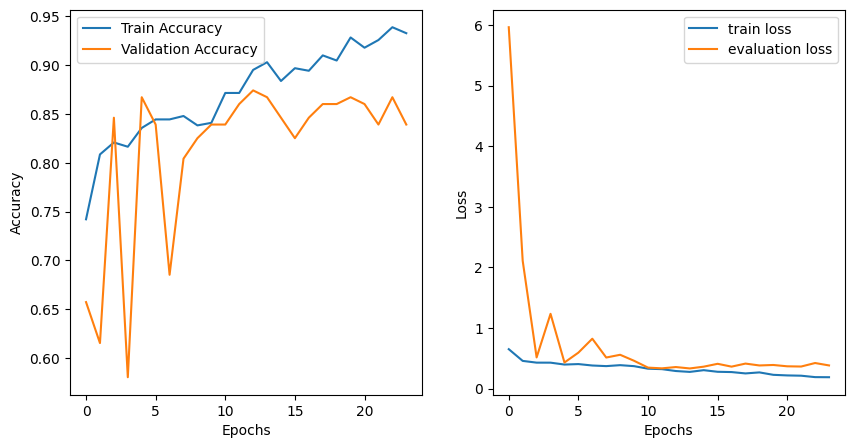

In [31]:
#gráficas
fig = plt.figure(figsize = (10,5))

#Accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_transfer.history['accuracy'], label = 'Train Accuracy');
ax.plot(history_transfer.history['val_accuracy'], label = 'Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();

#Loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(history_transfer.history['loss'], label = 'train loss');
ax.plot(history_transfer.history['val_loss'], label = 'evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8845 - auc: 0.9141 - loss: 0.3954 - precision: 0.8845 - recall: 0.8845
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step


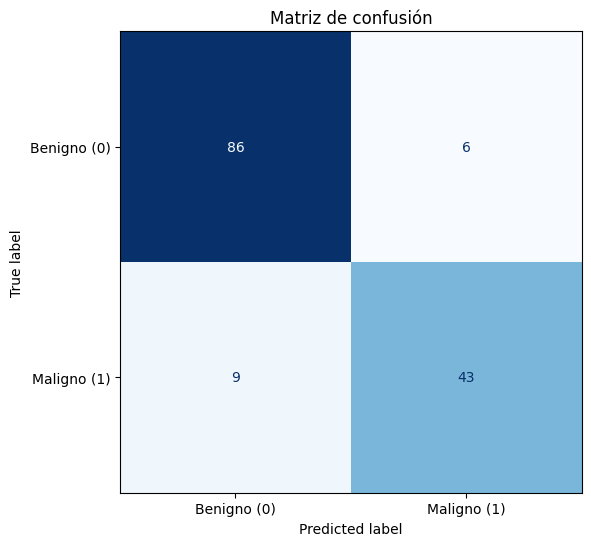

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

transfer_model.evaluate(X_test_224, y_test)
y_pred_proba = transfer_model.predict(X_test_224)
# Asegura que los vectores estén 1D
y_score = y_pred_proba  # probabilidades para todas las clases
y_true = np.argmax(y_test, axis=1)  # etiquetas verdaderas 0/1
y_hat = np.argmax(y_pred_proba, axis=1)  # predicciones 0/1

# 1) Matriz de confusión (absoluta)
cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
ax.set_title('Matriz de confusión')
plt.tight_layout()
plt.show()

(144, 2)


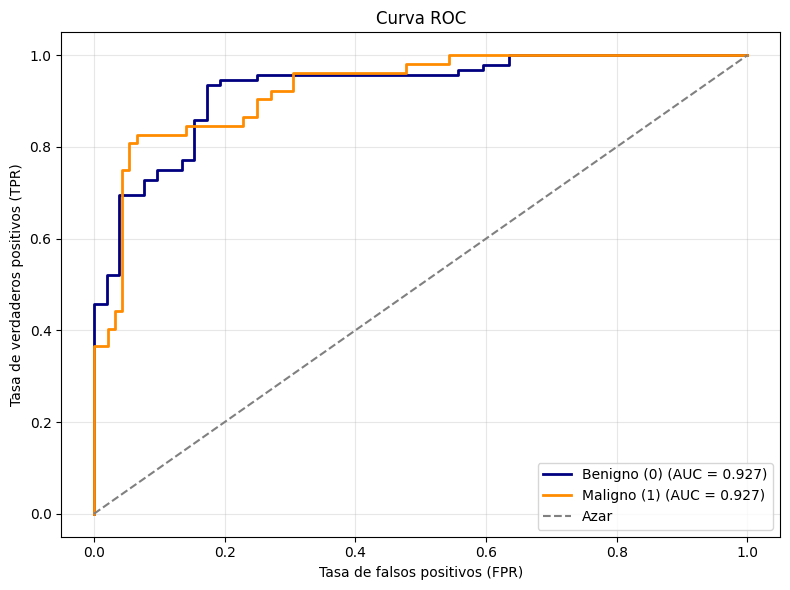

In [39]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

n_classes = 2
y_test_bin = label_binarize(y_test, classes=[0, 1])

print(y_test_bin.shape)

# 2) Curva ROC y AUC (multiclase)
plt.figure(figsize=(8, 6))

colors = cycle(['navy', 'darkorange'])
class_names = ['Benigno (0)', 'Maligno (1)']

for i, color, name in zip(range(3), colors, class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], '--', color='gray', label='Azar')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## CLASIFICACIÓN DE INDETERMINADOS

In [77]:
# Filtrar sólo los que tienen gold standard y sean indeterminados:
#  -1 = sin biopsia → se eliminan
df_gold = df[(df['gold_standard'] != -1) & (df['malignancy_agg'] == 3)].copy()
print("Casos con Gold Standard e indeterminados:", df_gold.shape)

Casos con Gold Standard e indeterminados: (38, 16)


In [78]:
import os
import numpy as np
import pandas as pd

# ============================
# 2️⃣ Extraer solo el nombre del archivo desde la ruta completa
# ============================
df_gold['filename'] = df_gold['best_match'].apply(lambda x: os.path.basename(str(x).strip()))

# ============================
# 3️⃣ Crear mapa filename → etiqueta
# ============================
map_labels = dict(zip(df_gold['filename'], df_gold['gold_standard']))

# ============================
# 4️⃣ Inicializar listas y contadores
# ============================
X_list_indet, Y_list_indet = [], []
skipped_no_label, corrupt_files, csv_missing_files = [], [], []

# ============================
# 5️⃣ Recorrer solo archivos .npy en tu carpeta
# ============================
for fname in os.listdir(path_npy):

    # ignorar cosas que no sean .npy
    if not fname.lower().endswith('.npy'):
        continue

    full_path = os.path.join(path_npy, fname)
    label = map_labels.get(fname)

    # si el archivo NO tiene gold standard → ignorar
    if label is None:
        skipped_no_label.append(fname)
        continue

    # cargar
    try:
        img = np.load(full_path)
        X_list_indet.append(img)
        Y_list_indet.append(label)
    except Exception as e:
        corrupt_files.append((fname, str(e)))

# ============================
# 6️⃣ Verificar archivos del CSV que no existen en la carpeta .npy
# ============================
for csv_fname in df_gold['filename'].unique():
    if not os.path.exists(os.path.join(path_npy, csv_fname)):
        csv_missing_files.append(csv_fname)

# ============================
# 7️⃣ Convertir a numpy arrays
# ============================
try:
    X_data_indet = np.stack(X_list_indet)
except Exception:
    X_data_indet = np.array(X_list_indet, dtype=object)

Y_data_indet = np.array(Y_list_indet)

# ============================
# 8️⃣ Resumen
# ============================
print("======================================")
print("       RESULTADO DE ALINEACIÓN        ")
print("======================================")
print("Total procesados:", len(X_list_indet))
print("Saltados sin gold standard:", len(skipped_no_label))
print("Corruptos:", len(corrupt_files))
print("En CSV pero no en carpeta .npy:", len(csv_missing_files))

print("\nShapes:")
print("  X_data_indet:", getattr(X_data_indet, 'shape', None))
print("  Y_data_indet:", Y_data_indet.shape)

print("\nEjemplo etiqueta:", Y_data_indet[:10])


       RESULTADO DE ALINEACIÓN        
Total procesados: 38
Saltados sin gold standard: 2587
Corruptos: 0
En CSV pero no en carpeta .npy: 0

Shapes:
  X_data_indet: (38,)
  Y_data_indet: (38,)

Ejemplo etiqueta: [1 1 1 1 1 0 1 0 0 0]


In [79]:
X_data_indet = resize_dataset_adaptive(X_data_indet, target_size=(224, 224))
X_data_indet = normalize_hounsfield_to_255_then_minmax(X_data_indet)

# Para transfer learning, convertir a 3 canales (RGB simulado)
# Muchos modelos pre-entrenados esperan 3 canales
X_data_indet = np.stack([X_data_indet]*3, axis=-1)

X_data_indet.shape
Y_data_indet.shape

Redimensionando a (224, 224): 100%|██████████| 38/38 [00:00<00:00, 4430.77it/s]


Windowing HU: [-1350, 150]


Normalizando (HU→255): 100%|██████████| 38/38 [00:00<00:00, 2660.07it/s]

Rango después de paso 1: [18.19, 255.00]
Paso 2 - Min-Max Scaler [0, 1]
Rango final: [0.0000, 1.0000]


(38,)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5455 - auc: 0.5303 - loss: 0.9923 - precision: 0.5455 - recall: 0.5455
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


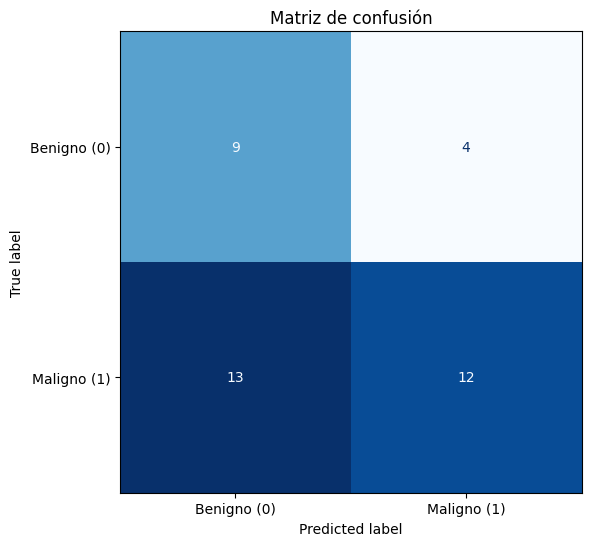

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

Y_data_indet = tf.keras.utils.to_categorical(Y_data_indet)
transfer_model.evaluate(X_data_indet, Y_data_indet)
y_pred_proba = transfer_model.predict(X_data_indet)
# Asegura que los vectores estén 1D
y_score = y_pred_proba  # probabilidades para todas las clases
y_true = np.argmax(Y_data_indet, axis=1)  # etiquetas verdaderas 0/1
y_hat = np.argmax(y_pred_proba, axis=1)  # predicciones 0/1

# 1) Matriz de confusión (absoluta)
cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
ax.set_title('Matriz de confusión')
plt.tight_layout()
plt.show()

# Modelo 2: AutoEncoder Anómalo

**Clase control:** Benigno

**Clase Anómala:** Maligno

In [26]:
# Extraer solo BENIGNOS para entrenar el autoencoder
mask_benigno = np.argmax(y_train, axis=1) == 0
mask_maligno = np.argmax(y_train, axis=1) == 1

X_train_auto = X_train[mask_benigno]
print("Dataset para autoencoder:", X_train_auto.shape)

Dataset para autoencoder: (727, 32, 32, 1)


In [16]:
from tensorflow.keras import layers, models

input_shape = X_train_auto.shape[1:]

input_img = layers.Input(shape=input_shape)

# ---------- Encoder ----------
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2), padding='same', name="embedding")(x) # Embebido

# ---------- Decoder ----------
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)

decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

autoencoder.summary()

I0000 00:00:1763997431.662454      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (MaxPooling2D)        │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(32, 32, 1))

x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)

# FLATTEN
x = layers.Flatten()(x)
encoded = layers.Dense(16, activation='relu')(x)   # ← BOTTLENECK REDUCIDO A 16

# DECODER
x = layers.Dense(8 * 8 * 64, activation='relu')(encoded)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        65,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,681 (819.07 KB)

 Trainable params: 209,681 (819.07 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#Compilar el modelo
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, 
                  loss='mse',
                  metrics=['mae'])

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, initial_lr=1e-3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

historyAE = autoencoder.fit(
    X_train_auto, X_train_auto,            
    epochs=100,
    validation_split = 0.2,  
    batch_size = 16,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0169 - mae: 0.0876 - val_loss: 0.0039 - val_mae: 0.0420 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - mae: 0.0398 - val_loss: 0.0026 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0024 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0328 - val_loss: 0.0023 - val_mae: 0.0323 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0318 - val_loss: 0.0022 - val_mae: 0.0321 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0315 - val_loss: 0.0022 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0310 - val_loss: 0.0022 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 8/100


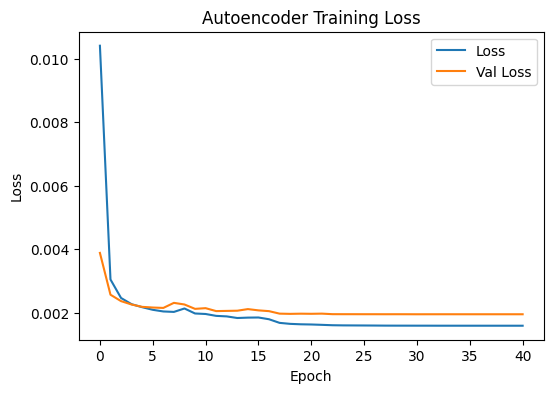

In [21]:
plt.figure(figsize=(6,4))
plt.plot(historyAE.history["loss"], label="Loss")
plt.plot(historyAE.history["val_loss"], label="Val Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
# Se testea tanto con malignos como benignos
encoded_imgs = encoder.predict(X_test)
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print("X_test shape:", X_test.shape)
print("X_pred shape:", X_pred.shape)
print("encoded_imgs shape:", encoded_imgs.shape)

# Se separan para visualizar reconstrucción en benignos y malignos
mask_benigno_test = np.argmax(y_test, axis=1) == 0
mask_maligno_test = np.argmax(y_test, axis=1) == 1

X_test_benigno = X_test[mask_benigno_test]
X_pred_benigno = X_pred[mask_benigno_test]
encoded_benigno = encoded_imgs[mask_benigno_test]

X_test_maligno = X_test[mask_maligno_test]
X_pred_maligno = X_pred[mask_maligno_test]
encoded_maligno = encoded_imgs[mask_maligno_test]

#Code for visualize the results
import matplotlib.pyplot as plt
import numpy as np

def visualizar_autoencoder(X, X_pred, encoded, titulo, n=10):
    plt.figure(figsize=(24, 8))
    plt.suptitle(titulo, fontsize=25)

    for i in range(n):

        # ORIGINAL
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X[i].reshape(32, 32), cmap='gray')
        ax.axis('off')

        # EMBEDDING (reformateado a 32x64)
        ax = plt.subplot(3, n, i + 1 + n)
        emb = encoded[i].flatten().reshape(32, 64) #!!!! 32,64 || 4,4
        plt.imshow(emb, cmap='gray')
        ax.axis('off')

        # RECONSTRUCCIÓN
        ax = plt.subplot(3, n, 2*n + i + 1)
        plt.imshow(X_pred[i].reshape(32, 32), cmap='gray')
        ax.axis('off')

    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
X_test shape: (144, 32, 32, 1)
X_pred shape: (144, 32, 32, 1)
encoded_imgs shape: (144, 4, 4, 128)


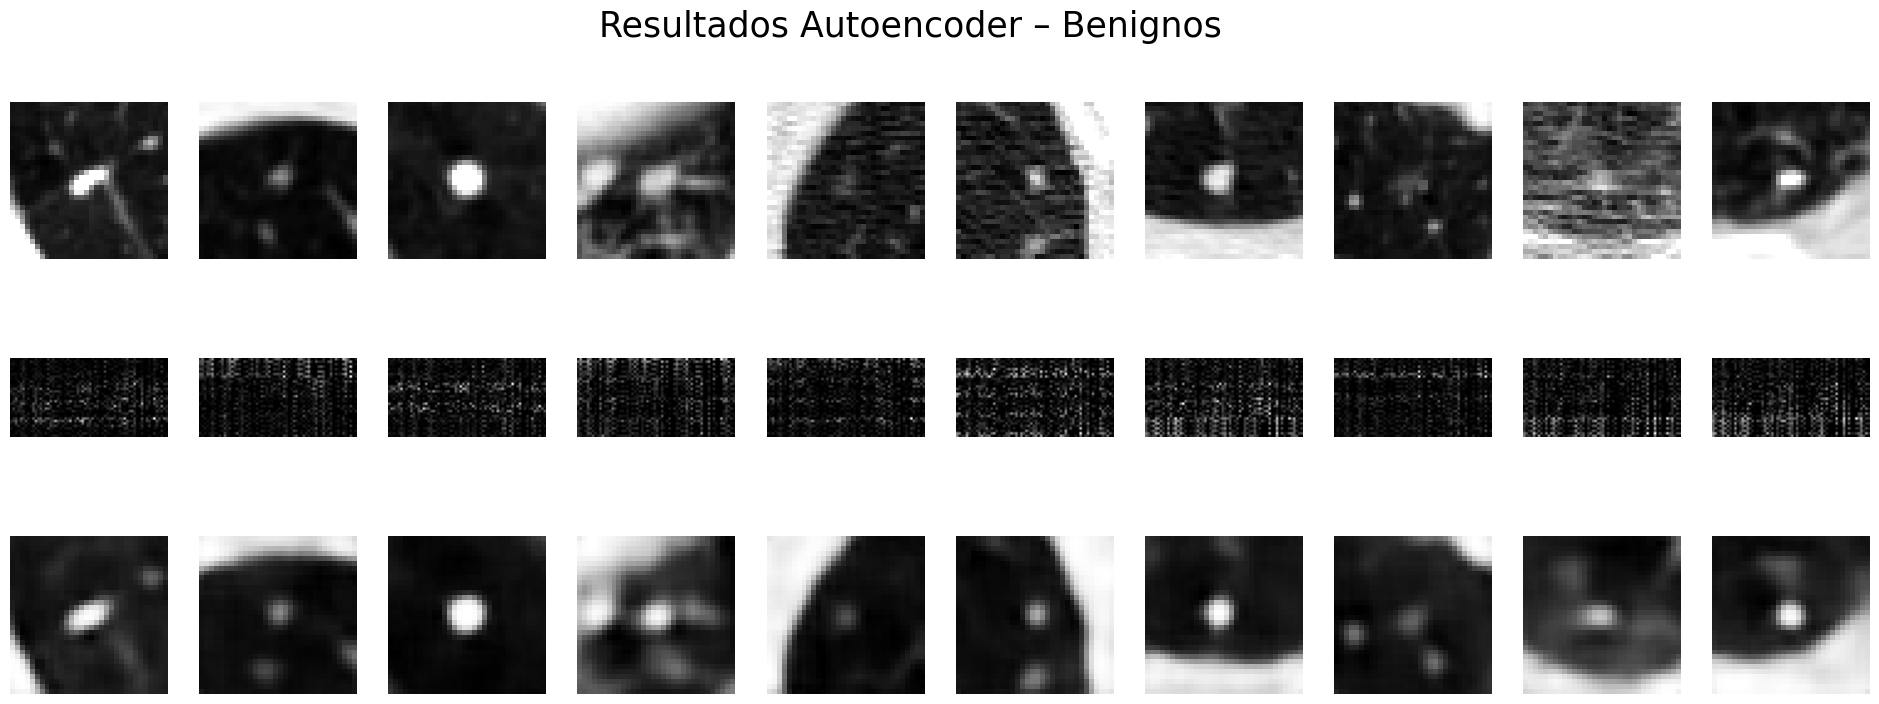

In [27]:
#Visualización de benignos
visualizar_autoencoder(
    X_test_benigno,
    X_pred_benigno,
    encoded_benigno,
    "Resultados Autoencoder – Benignos",
    n=10
)


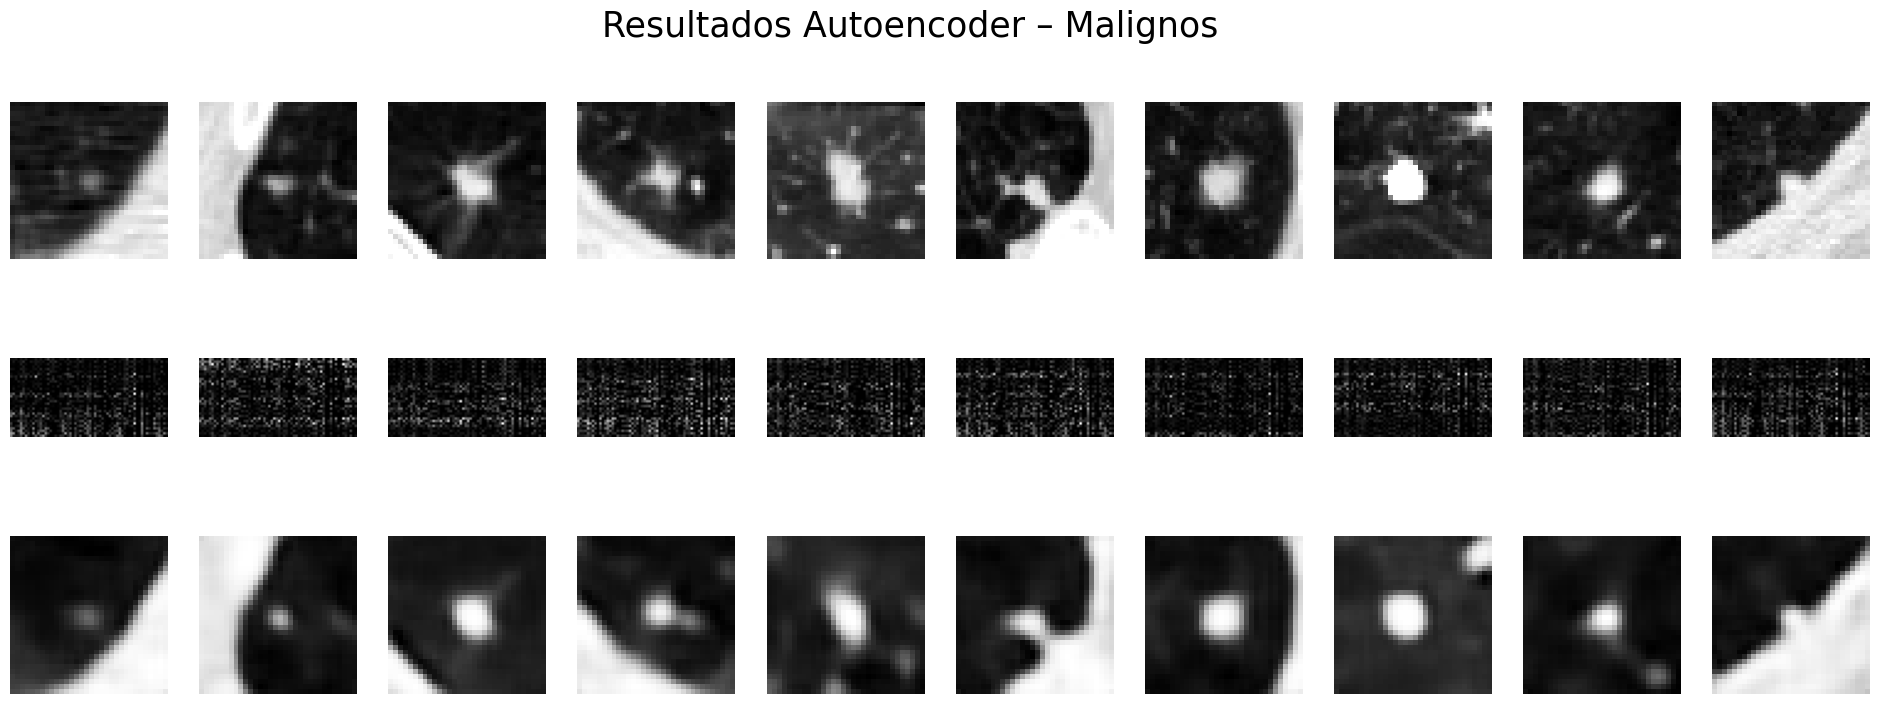

In [28]:
#Visualización de malignos
visualizar_autoencoder(
    X_test_maligno,
    X_pred_maligno,
    encoded_maligno,
    "Resultados Autoencoder – Malignos",
    n=10
)

In [29]:
mse_benigno = np.mean((X_test_benigno - X_pred_benigno)**2, axis=(1,2,3))
mse_maligno = np.mean((X_test_maligno - X_pred_maligno)**2, axis=(1,2,3))

print("MSE benignos promedio:", np.mean(mse_benigno))
print("MSE malignos promedio:", np.mean(mse_maligno))

MSE benignos promedio: 0.002215261429733548
MSE malignos promedio: 0.0042245723433903945


In [38]:
y_test_labels = np.argmax(y_test, axis=1)
# Error cuadrático medio por imagen
ecm = np.mean((X_test - X_pred)**2, axis=(1,2,3))

In [32]:
# Trheshold
# Error en benignos del entrenamiento
X_train_pred = autoencoder.predict(X_train_auto)
ecm_train = np.mean((X_train_auto - X_train_pred)**2, axis=(1,2,3))

# Threshold recomendado
threshold = np.percentile(ecm_train, 95)  # Very common in anomaly detection

print("Threshold seleccionado:", threshold)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Threshold seleccionado: 0.0039030788483713718


In [34]:
# Clasificación
y_pred = (ecm > threshold).astype(int)

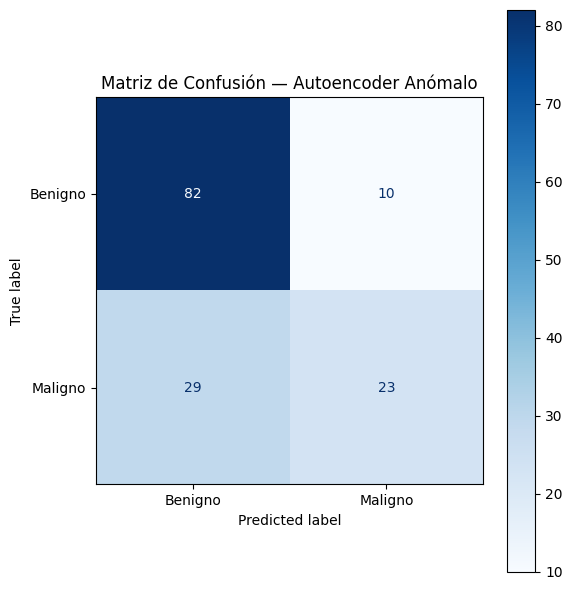

In [35]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labels, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benigno', 'Maligno']
)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title("Matriz de Confusión — Autoencoder Anómalo")
plt.tight_layout()
plt.show()


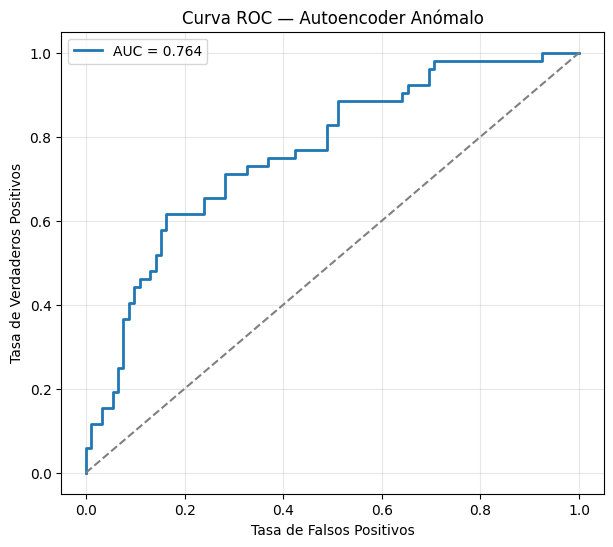

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_labels, ecm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')

plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC — Autoencoder Anómalo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
